<a href="https://colab.research.google.com/github/nekeal/mwsis/blob/master/%C4%86wiczenia_modelowanie_probabilistyczne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import collections
tfd=tfp.distributions
tfb=tfp.bijectors
sns.set()

In [ ]:
# x = np.random.normal(0., 1.,size=40)
# y = 0.9*x - 0.5 + np.random.normal(scale=0.5, size=x.shape)
# y = 2*x + 0.9* x**2+4 + np.random.normal(scale=0.4, size=x.shape)

# zły model +0.6*x**2

x=np.random.rand(100)*2-1
scale=0.2
y = 0.5*x  - 0.3 + np.random.normal(scale=scale, size=x.shape)

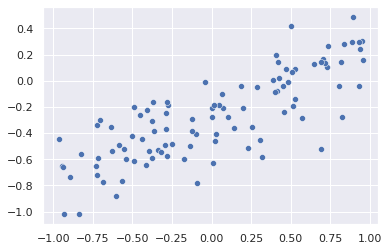

In [ ]:
sns.scatterplot(x=x,y=y)

In [ ]:
joint = tfd.JointDistributionNamed(dict(
    beta0 = tfd.Laplace(loc=0., scale=2.),
    beta1=tfd.Normal(loc=0, scale=2.),
    sigma=tfd.Gamma(4., 4.),
    y=lambda beta0, beta1, sigma: tfd.Independent(tfd.Normal(
        loc = beta0[..., tf.newaxis] + beta1[..., tf.newaxis]*x[np.newaxis, ...], 
        scale = sigma[..., tf.newaxis]
    ), reinterpreted_batch_ndims=1)
))

In [ ]:
def target_log_prob(beta0, beta1, sigma):
  return joint.log_prob(beta0=beta0,beta1=beta1, sigma=sigma, y=y[np.newaxis,...])

# MLE


In [ ]:
y_dist = tfp.distributions.Normal(
    loc=tfp.util.DeferredTensor(tf.Variable([0.0, 1.0]),
                                lambda beta: beta[0] + beta[1]*x, 
                                shape=x.shape),
    scale=tfp.util.TransformedVariable([1.], bijector=tfp.bijectors.Softplus())
    )

In [ ]:
losses = tfp.math.minimize(lambda : -tf.reduce_sum(y_dist.log_prob(y)),
                           num_steps=2000,
                           optimizer=tf.optimizers.Adam(learning_rate=0.2))

In [ ]:
y_dist.variables, y_dist.stddev()[0]

((<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([-0.27748933,  0.47266382], dtype=float32)>,
  <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([-1.528625], dtype=float32)>),
 <tf.Tensor: shape=(), dtype=float32, numpy=0.19625208>)

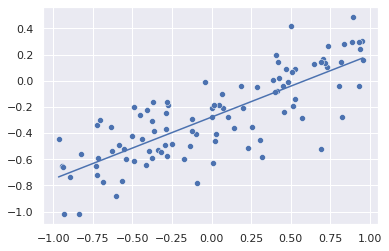

In [ ]:
sns.scatterplot(x=x,y=y)
sns.lineplot(x=x, y=y_dist.mean())

In [ ]:
start_dist = tfd.JointDistributionNamed(dict(
    beta0=tfd.Normal(y_dist.variables[0][0],0.01),
    beta1=tfd.Normal(y_dist.variables[0][1],0.02),
    sigma=tfd.Normal(y_dist.stddev()[0],0.006)
))

# MCMC

In [ ]:
hmc = tfp.mcmc.NoUTurnSampler(
    target_log_prob_fn=target_log_prob,
    step_size=[.015,.025, 0.0065])

hmc = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc,
    bijector=[
              tfp.bijectors.Identity(),
              tfp.bijectors.Identity(),
              tfp.bijectors.Softplus(),  # s1
    ])

hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=hmc,
    num_adaptation_steps=1000,
    target_accept_prob=.7)

joint_sample = joint.sample(10)
joint_sample = start_dist.sample(5)
#joint_sample = q.sample(5)
initial_state = [
    joint_sample['beta0'],
    joint_sample['beta1'],
    joint_sample['sigma'],
]

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/__init__.py:71: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  'TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The '


In [ ]:
@tf.function(autograph=False, experimental_compile=True)
def run():
  return tfp.mcmc.sample_chain(
      num_results=500,
      current_state=initial_state,
      kernel=hmc,
      num_burnin_steps=100,
      trace_fn=lambda _, kr: kr)

samples, traces = run()
print('R-hat diagnostics: ', tfp.mcmc.potential_scale_reduction(samples))


R-hat diagnostics:  [<tf.Tensor: shape=(), dtype=float32, numpy=0.998428>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0010915>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0028709>]


In [ ]:
np.mean(traces.inner_results.inner_results.is_accepted)


0.8808

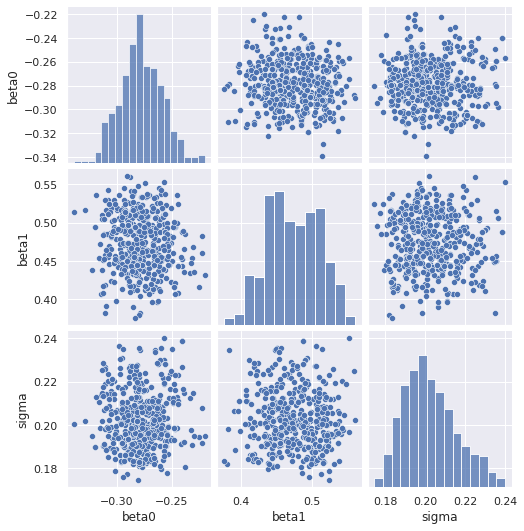

In [ ]:
import pandas as pd

# df = pd.DataFrame(dict(
#     beta0=samples[0].numpy().flatten(),
#     beta1=samples[1].numpy().flatten(),
#     sigma = samples[2].numpy().flatten()
# ))

df = pd.DataFrame(dict(
    beta0=samples[0].numpy()[:,0],
    beta1=samples[1].numpy()[:,0],
    sigma = samples[2].numpy()[:,0]
))


sns.pairplot(df,diag_kind='hist')

In [ ]:
#tf.nest.map_structure(tf.math.reduce_mean, samples)
df.mean()

beta0   -0.277526
beta1    0.473543
sigma    0.202683
dtype: float32

In [ ]:
#tf.nest.map_structure(tf.math.reduce_std, samples)
df.std()

beta0    0.019077
beta1    0.036880
sigma    0.013257
dtype: float32

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Krzysztof Rusek: n=100, s=0.2')

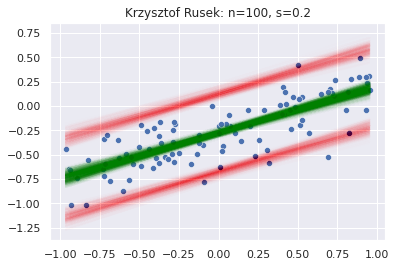

In [ ]:
sns.scatterplot(x,y)

for b0, b1, s in zip(samples[0][:,0], samples[1][:,0], samples[2][:,0]):
  plt.plot(x, b0+b1*x , color='green', alpha=0.02)
  plt.plot(x, b0+b1*x + 2*s, color='red', alpha=0.005)
  plt.plot(x, b0+b1*x - 2*s, color='red', alpha=0.005)
plt.title(f'Krzysztof Rusek: n={len(x)}, s={scale}')

In [ ]:
q = tfd.JointDistributionNamed(dict(
                                     beta0=tfd.Normal(loc=tf.Variable(0.),
                                                scale=tfp.util.TransformedVariable(1.5, tfp.bijectors.Softplus(),
                                                    )),
                                      beta1=tfd.Normal(loc=tf.Variable(0.),
                                                scale=tfp.util.TransformedVariable(1.5, tfp.bijectors.Softplus(),
                                                    )),
                                      sigma=tfd.Normal(loc=tf.Variable(2.),
                                                scale=tfp.util.TransformedVariable(0.01, tfp.bijectors.Softplus(),
                                                    ))
                                      
))
                                                


In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    target_log_prob,
    surrogate_posterior=q,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=1000,
    sample_size=10)


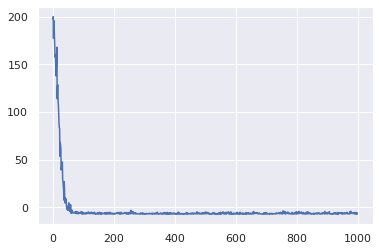

In [ ]:
plt.plot(losses)

In [ ]:
std=q.stddev()

for k,v in q.mean().items():
  print("{}: {:.4f} ± {:.4f} ".format(k,v.numpy(),2*std[k].numpy()))


sigma: 0.1889 ± 0.0239 
beta1: 0.4582 ± 0.0768 
beta0: -0.2874 ± 0.0425 


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


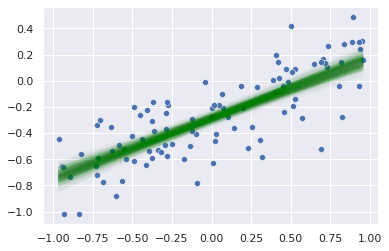

In [ ]:
sns.scatterplot(x,y)

for s, b1, b0 in zip(*list(q.sample(500).values())):
  plt.plot(x, b0+b1*x , color='green', alpha=0.01)

# Zadanie


Zabdać model dla

$\sigma$

- 0.05
- 0.1
- 0.5

i $N$

- 3
- 10
- 1000

Dodatkwo sprawdzić dopasowanie modleu liniowego do danych wylosowanych z $0.6 x^2 +0.5 x  - 0.3$

### Niepewność

- **Eleatoryczna** mierzona przez $\sigma$ określa szum w danych
- **Epistemiczba** mierzona przez a posteriori odpowiada za brak wiedzy ze względu na mało danych




# Łacza

a1,a2,a3 to pomiary ruchu (odstepy pomiedzy pakietami)

Chcemy wyznaczyć wszytskie intensywności i prawdopodobieństwo utraty pakietu



## Notatka

Alternatywa

```python
l1=20
l2=40

pb=1/10

l3= (1-pb)*(l1+l2)

T=20

n1= tfd.Poisson(T*l1).sample()
n2= tfd.Poisson(T*l2).sample()

nd = tfd.Binomial(n1+n2, probs=pb).sample()
# bufor + przychodzace - straty
n3 = 120 + n1+n2-nd
```

In [ ]:
l1=20
l2=40

pb=1/10

l3= (1-pb)*(l1+l2)

n1=200
n2=200
n3=200


a1 = tfd.Exponential(l1).sample(n1).numpy()
a2 = tfd.Exponential(l2).sample(n2).numpy()
a3 = tfd.Exponential(l3).sample(n3,seed=32).numpy()

In [ ]:
print(l3),1/a3.mean()

54.0


(None, 57.965213804868306)

In [ ]:
def l3_fn(l1,l2,p):
  return tfd.Deterministic((1.-p)*(l1+l2))

model = tfd.JointDistributionNamed(dict(
    l1 = tfd.Gamma(2.,2/100.),
    l2 = tfd.Gamma(2.,2/100.),
    p = tfd.Beta(1.,1.),
    l3=l3_fn,
    a1 = lambda l1: tfd.Sample(tfd.Exponential(l1),len(a1)),
    a2 = lambda l2: tfd.Sample(tfd.Exponential(l2), len(a2)),
    a3 = lambda l3: tfd.Sample(tfd.Exponential(l3), len(a3)),
))

In [ ]:
q=tfd.JointDistributionNamed(dict(
    l1 = tfd.TransformedDistribution(tfd.Normal(tf.Variable(1./a1.mean(), dtype=tf.float32), 
                    tfp.util.TransformedVariable(1.,tfp.bijectors.Softplus(), dtype=tf.float32)
                    ),tfb.Softplus()),
    l2 = tfd.TransformedDistribution(tfd.Normal(tf.Variable(np.float32(1.)/a2.mean()), 
                    tfp.util.TransformedVariable(1.,tfp.bijectors.Softplus(), dtype=tf.float32)
                    ),tfb.Softplus()),
    p = tfd.TransformedDistribution(tfd.Normal(tf.Variable(np.float32(1.)-(np.float32(1.)/a1.mean())/(np.float32(1.)/a1.mean()+np.float32(1.)/a2.mean())),
                   tfp.util.TransformedVariable(1.,tfp.bijectors.Softplus(), dtype=tf.float32)
                   ),tfb.Sigmoid()),
    l3 = l3_fn

))

In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    lambda l1,l2,l3, p: model.log_prob(l1=l1,l2=l2,l3=l3,p=p,a1=a1, a2=a2,a3=a3),
    surrogate_posterior=q,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=1000,
    sample_size=50)


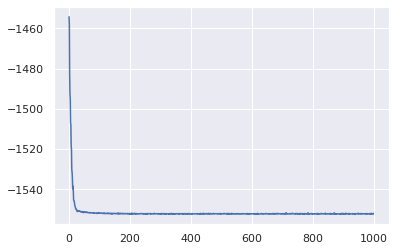

In [ ]:
plt.plot(losses)

In [ ]:
df = pd.DataFrame(q.sample(10000))
pd.DataFrame({'mean':df.mean(), 'std':df.std()})

,mean,std
p,0.086448,0.051139
l2,37.111458,2.211684
l1,24.019569,1.629890
l3,55.848511,4.042386


3.5979409217834473


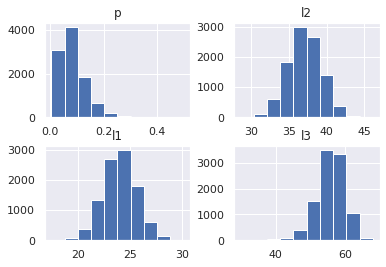

In [ ]:
df.hist();
print(np.mean(np.abs(df.l3-l3)))

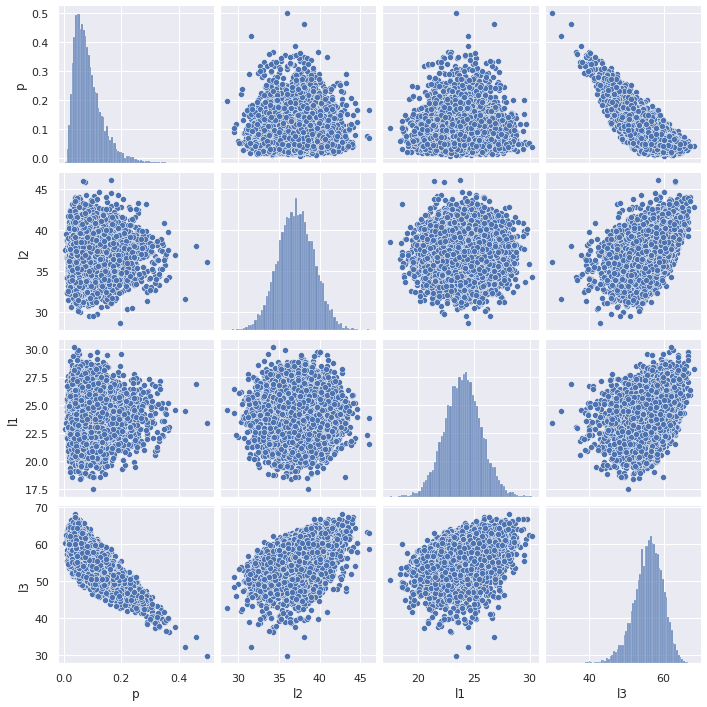

In [ ]:
sns.pairplot(df)

In [ ]:
model_l3 = tfd.JointDistributionNamed(dict(
    l3 = tfd.Gamma(2.,2/100.),
    a3 = lambda l3: tfd.Sample(tfd.Exponential(l3), len(a3)),
))

In [ ]:
q_l3=tfd.JointDistributionNamed(dict(
    l3 = tfd.TransformedDistribution(tfd.Normal(tf.Variable(1./a3.mean(), dtype=tf.float32), 
                    tfp.util.TransformedVariable(1.,tfp.bijectors.Softplus(), dtype=tf.float32)
                    ),tfb.Softplus())
))

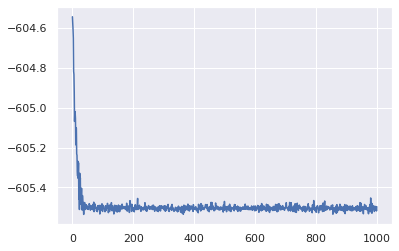

In [ ]:
losses = tfp.vi.fit_surrogate_posterior(
    lambda l3: model_l3.log_prob(l3=l3,a3=a3),
    surrogate_posterior=q_l3,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=1000,
    sample_size=50)
plt.plot(losses)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


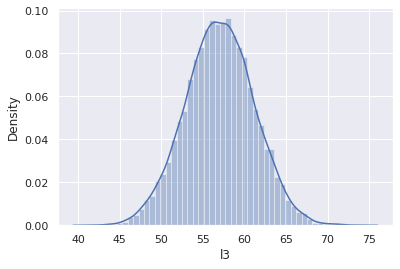

In [ ]:
s = pd.DataFrame(q_l3.sample(10000))
sns.distplot(s['l3'])

In [ ]:
pd.DataFrame({'mean':s.mean(), 'std':s.std()})

,mean,std
l3,57.032711,4.118153


In [ ]:
np.mean(np.abs(s.l3-l3)),np.mean(np.abs(df.l3-l3))

(4.138150691986084, 3.5979409217834473)